1 Import user check-ins to a data frame from original data:csv

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from math import sqrt
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse.linalg import svds

In [2]:
data=pd.read_csv('original_data.csv')
data.head()

user_id  location_id        v1          v2   time  dur
0        0          579  1.372495  103.893714  14:03   27
1        0          579  1.372495  103.893714  21:54  139
2        0          821  1.293144  103.853245   9:31   37
3        0          927  1.264248  103.823054  16:17  139
4        0          955  1.337012  103.779062  19:52   31

2 Create a new data frame with three separate columns "User id; Location id,
and Checkin frequency"

In [3]:
columns=('user_id','location_id')

In [4]:
sub=data.loc[:,columns]
newdata=sub.groupby(['user_id','location_id']).size().reset_index(name='Checkin-frequency')

4 Inspect the dataset looking at the number of unique users, unique locations

In [5]:
n_users=len(newdata.user_id.unique())

In [6]:
n_locations=len(newdata.location_id.unique())

5 Use Sklearn model selection library to Split the dataset into train and
test sets

In [7]:
train_data, test_data =ms.train_test_split(newdata,test_size=0.20)


In [8]:
train_data.shape

(65941, 3)

In [9]:
test_data.shape

(16486, 3)

6 Make predictions for check-ins which are not included in the dataset using
memory-based collaborative filtering
- Create two user_location matrices. One matrix is for train data
and the other one for test data. The size of each matrix is Number_
of_users Number_of_locations. Create empty matrices first
and all these matrices using the train and test split datasets you had
created before.
- Measure the user similarities using cosine similarity. To measure co-
sine similarity you can use pairwise distance from sklearn.metrics.pairwise
- Measure the item similarities using cosine similarity
- Predict that a users ui checkin for location i is given by the weighted
sum of all other users check-in for location i where the weighting is
the cosine similarity between the each user and the input user u. Test
this prediction on training dataset for both user-user and item-item
collaborative filter.
- Evaluate the results by measuring the RMSE (both user-based and
item-based). For calculating RMSE you can get the square root of
the function MSE in sklearn. Compare the predictions on the train
dataset against the test dataset.

In [10]:
train_data_matrix = np.zeros((n_users, n_locations))
for checkin in train_data.itertuples():
    train_data_matrix[checkin[1], checkin[2]] = checkin[3]
# for RMSE
test_data_matrix = np.zeros((n_users, n_locations))
# for Precision and Recall
ground_truth_dic = defaultdict(set)

test_data_matrix = np.zeros((n_users, n_locations))
for checkin in test_data.itertuples():
    test_data_matrix[checkin[1], checkin[2]] = checkin[3]
    ground_truth_dic[int(checkin[1])].add(int(checkin[2]))


In [11]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [12]:
np.count_nonzero(train_data_matrix)

65941

In [13]:
def predict(checkins, similarity, type='user'):
    if type == 'user':
        pred = similarity.dot(checkins)/np.array([np.abs(similarity).sum(axis=1)]).T
        
    elif type == 'item':
        pred = checkins.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
        
    return pred

user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

In [14]:
def rmse(prediction, ground_truth):
    # prediction[ground_truth.nonzero()] to only consider predicted checkins
    # (ratings) that are in the dataset.
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [15]:
UB_RMSE = rmse(user_prediction, test_data_matrix)
IB_RMSE = rmse(item_prediction, test_data_matrix)
print('>> User-based CF RMSE: ' + str(UB_RMSE))
print('>> Item-based CF RMSE: ' + str(IB_RMSE))

>> User-based CF RMSE: 4.04799821709199
>> Item-based CF RMSE: 4.063517267909895


7 Make predictions for check-ins which are not included in the dataset using
model-based collaborative filtering
- Decompose the matrix to u, s, vt matrices
- make predictions based on model learnt
- Measure the RMSE distance between predictions and test data ma-
trix recall and percision@5,10,15,20)

In [16]:

#get SVD components from train matrix. Choose k as r in formula.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix = np.diag(s)
svd_prediction = np.dot(np.dot(u, s_diag_matrix), vt)
SVD_RMSE = rmse(svd_prediction, test_data_matrix)
print('>> Model-based CF RMSE: ' + str(SVD_RMSE))

>> Model-based CF RMSE: 3.9931118044089784


8. Measure the RMSE, recall and percision@5,10,15,20 distance between pre-
dictions and test data matrix. Compare the RMSE error/precision and
recall errors results in a bar chart

In [17]:
objects = ('User-Based', 'Item-Based', 'SVD')
y_pos = np.arange(len(objects))
performance = [UB_RMSE,IB_RMSE,SVD_RMSE]
 
plt.bar(y_pos, performance, color=['red', 'green', 'blue'], 
        align='center', alpha=0.6)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.title('Comparison of methods based on RMSE')
plt.show()

In [18]:
uPrecision5, uPrecision10, uPrecision15, uPrecision20 = [], [], [], []
iPrecision5, iPrecision10, iPrecision15, iPrecision20 = [], [], [], []
sPrecision5, sPrecision10, sPrecision15, sPrecision20 = [], [], [], []

uRecall5, uRecall10, uRecall15, uRecall20 = [], [], [], []
iRecall5, iRecall10, iRecall15, iRecall20 = [], [], [], []
sRecall5, sRecall10, sRecall15, sRecall20 = [], [], [], []

def precision_k(actual, predicted):
    return 1.0 * len(set(actual) & set(predicted)) / len(predicted)


def recall_k(actual, predicted):
    return 1.0 * len(set(actual) & set(predicted)) / len(actual)

all_uids = list(range(n_users))
all_lids = list(range(n_locations))
np.random.shuffle(all_uids)

for cnt, uid in enumerate(all_uids):
    if uid in ground_truth_dic:
        user_scores = [user_prediction[uid, lid]
                        if train_data_matrix[uid, lid] == 0 else -1
                            for lid in all_lids]
        
        item_scores = [item_prediction[uid, lid]
                        if train_data_matrix[uid, lid] == 0 else -1
                            for lid in all_lids]
        
        svd_scores = [svd_prediction[uid, lid]
                        if train_data_matrix[uid, lid] == 0 else -1
                            for lid in all_lids]
                
        user_scores = np.array(user_scores)
        item_scores = np.array(item_scores)
        svd_scores = np.array(svd_scores)
        
        user_predicted = list(reversed(user_scores.argsort()))[:100]
        item_predicted = list(reversed(item_scores.argsort()))[:100]
        svd_predicted = list(reversed(svd_scores.argsort()))[:100]
        
        actual = ground_truth_dic[uid]
        
        k = [5, 10, 15, 20]
        
        for i in k:
            u_precision = precision_k(actual, user_predicted[:i])
            u_recall = recall_k(actual, user_predicted[:i])
            
            i_precision = precision_k(actual, item_predicted[:i])
            i_recall = recall_k(actual, item_predicted[:i])
            
            s_precision = precision_k(actual, svd_predicted[:i])
            s_recall = recall_k(actual, svd_predicted[:i])
            
            if i == 5:
                uPrecision5.append(u_precision)
                iPrecision5.append(i_precision)
                sPrecision5.append(s_precision)
                
                uRecall5.append(u_recall)
                iRecall5.append(i_recall)
                sRecall5.append(s_recall)
                
            elif i == 10:
                uPrecision10.append(u_precision)
                iPrecision10.append(i_precision)
                sPrecision10.append(s_precision)
                
                uRecall10.append(u_recall)
                iRecall10.append(i_recall)
                sRecall10.append(s_recall)
                
            elif i == 15:                
                uPrecision15.append(u_precision)
                iPrecision15.append(i_precision)
                sPrecision15.append(s_precision)
                
                uRecall15.append(u_recall)
                iRecall15.append(i_recall)
                sRecall15.append(s_recall)
                
            elif i == 20:
                uPrecision20.append(u_precision)
                iPrecision20.append(i_precision)
                sPrecision20.append(s_precision)
                
                uRecall20.append(u_recall)
                iRecall20.append(i_recall)
                sRecall20.append(s_recall)            

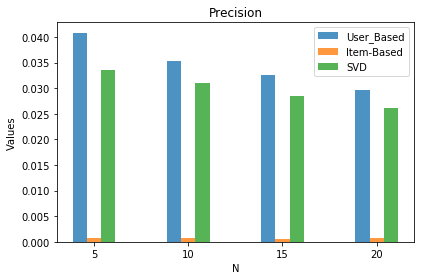

In [19]:
# data to plot
n_groups = 4
user = (np.mean(uPrecision5), np.mean(uPrecision10), 
        np.mean(uPrecision15), np.mean(uPrecision20))
item = (np.mean(iPrecision5), np.mean(iPrecision10), 
        np.mean(iPrecision15), np.mean(iPrecision20))
svd = (np.mean(sPrecision5), np.mean(sPrecision10), 
       np.mean(sPrecision15), np.mean(sPrecision20))
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, user, bar_width, alpha=opacity, label='User_Based') 
rects2 = plt.bar(index + bar_width, item, bar_width, 
                 alpha=opacity, label='Item-Based')
rects3 = plt.bar(index + bar_width + bar_width, svd, 
                 bar_width, alpha=opacity, label='SVD')
 
plt.xlabel('N')
plt.ylabel('Values')
plt.title('Precision')
plt.xticks(index + bar_width, ('5', '10', '15', '20'))
plt.legend()
 
plt.tight_layout()
plt.show()

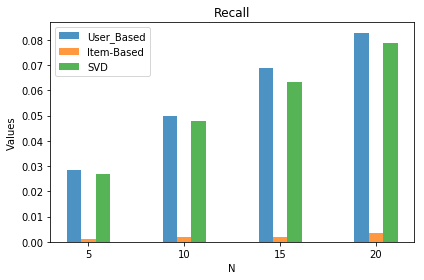

In [20]:
# data to plot
n_groups = 4
user = (np.mean(uRecall5), np.mean(uRecall10), 
        np.mean(uRecall15), np.mean(uRecall20))
item = (np.mean(iRecall5), np.mean(iRecall10), 
        np.mean(iRecall15), np.mean(iRecall20))
svd = (np.mean(sRecall5), np.mean(sRecall10), 
       np.mean(sRecall15), np.mean(sRecall20))
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, user, bar_width, alpha=opacity, label='User_Based') 
rects2 = plt.bar(index + bar_width, item, bar_width, 
                 alpha=opacity, label='Item-Based')
rects3 = plt.bar(index + bar_width + bar_width, svd, 
                 bar_width, alpha=opacity, label='SVD')
 
plt.xlabel('N')
plt.ylabel('Values')
plt.title('Recall')
plt.xticks(index + bar_width, ('5', '10', '15', '20'))
plt.legend()
 
plt.tight_layout()
plt.show()

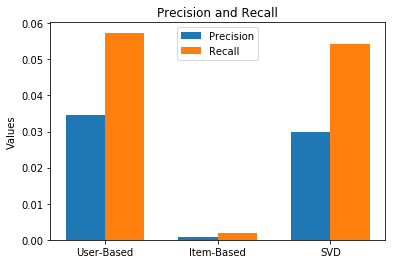

In [21]:
N = 3
means_precision = (np.mean(uPrecision5 + uPrecision10 + uPrecision15 + uPrecision20),
                   np.mean(iPrecision5 + iPrecision10 + iPrecision15 + iPrecision20),
                   np.mean(sPrecision5 + sPrecision10 + sPrecision15 + sPrecision20))

means_recall = (np.mean(uRecall5 + uRecall10 + uRecall15 + uRecall20),
                   np.mean(iRecall5 + iRecall10 + iRecall15 + iRecall20),
                   np.mean(sRecall5 + sRecall10 + sRecall15 + sRecall20))

ind = np.arange(N) 
width = 0.35

plt.bar(ind, means_precision, width, label='Precision')
plt.bar(ind + width, means_recall, width, label='Recall')

plt.ylabel('Values')
plt.title('Precision and Recall')

plt.xticks(ind + width / 2, ('User-Based', 'Item-Based', 'SVD'))
plt.legend(loc='best')
plt.show()